# AIS in written English

Author: J. Lizier, 2023-; based on the original Matlab tutorials.

In this activity we will revisit the written English data set we first use in Module 2, considering it as a time series (where later characters have later time indices), and examine Active Information Storage (AIS) that past characters provide about the next.

1. We will start by taking copies of relevant parts of your saved code from the CA activity in the AIS module. We are going to use that code to recreate a similar bias corrected AIS versus k plot for this data set.
    1. For the first cell below, copy and paste the import/startup lines from your CA notebook.
    2. For the second cell below, leave the code as is, aside from changing the path to where your data set is. Notice that there is a little more data plumbing this time. The vector `processedStr` holds each character in character format, but we will need to supply our symbols to JIDT as integers in the range `[0,alphabetSize-1]`, where `alphabetSize` is 27 (26 letters plus the space). So we convert the `processedStr` to a time series of integers.
    3. For the third cell, copy and paste the code from the CA notebook which computed and plotted AIS vs k (the last code cell before we went on to examine the local AIS values).
2. Now, make sure to delete the lines in the third cell which load in the CA data (we're no longer using this!)
3. Now, let's check what we need to change about the calculation of AIS for each value of k in the main loop:
    1. When we worked with the CAs, the alphabet size we were dealing with there was 2. For this data set it will be 27. Can you see where we tell the estimator this? If unsure, go back to the AutoAnalyser, change the `base` parameter to 27, and see where this is placed in the generated code.
    2. Remove the loop over variables `v` in the code, since we've only got one time series here (unlike the CAs example where we have a time series for each cell or variable `v`). Pass your whole time series `data` to the estimator in a single call to `calc.addObservations()`
4. Finally, change your loop over the value of `k` to stop at 4. At the moment, the multivariate state space here for `k=5` with an alphabet size of 27 is too large for JIDT to handle (I have some new algorithms coming!).

In [1]:
# Paste the import and JVM startup lines here (copy from the CA activity):

from jpype import *
import numpy
import sys
# Our python data file readers are a bit of a hack, python users will do better on this:
sys.path.append("/home/joseph/JIDT/infodynamics-dist-1.6.1/demos/python")
import readIntsFile

if (not isJVMStarted()):
    # Add JIDT jar library to the path
    jarLocation = "/home/joseph/JIDT/infodynamics-dist-1.6.1/infodynamics.jar"
    # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation, convertStrings=True)

In [2]:
# Specifics required for the text processing here:
import string
import re

# Load and pre-parse the scripts
filename = '/home/joseph/TeachingPlayground/CSYS5030/WrittenText/Seinfeld-scripts-textOnly.txt'
with open(filename, 'rt') as f:
    str = f.read()
p = re.compile('[!"#\$%&\'\(\)\*\+\,-\.\/:;<=>\?@\[\]\\\^_`{\|}~0-9]*');
processedStr = p.sub('', str); # Remove punctuation characters and digits
processedStr = ' '.join(processedStr.split('\n')); # Replace newline characters with spaces
processedStr = processedStr.lower(); # Convert all upper case into lower case
processedStr = numpy.array(list(processedStr)); # Finally convert this into a numpy array so we can work with it
numpy.unique(processedStr)

data = processedStr.view(numpy.int32) - ord('a'); # Converts the letters to an integer representing their offset from 'a'.
# Use of int32 rather than int64 is important to ensure compatibility with Java int size.
# But spaces have been turned into the value ord(' ') - ord('a') (i.e. the difference in character encodings of space and 'a').
# We need to replace this with the integer value 26, such that all of our symbols are consecutive for JIDT:
data[data == ord(' ') - ord('a')] = 26;

AIS_Discrete(k=1, 2711979 samples) = 0.7196 bits (bias 0.0001, bias corrected 0.7195)
AIS_Discrete(k=2, 2711978 samples) = 1.4587 bits (bias 0.0035, bias corrected 1.4552)
AIS_Discrete(k=3, 2711977 samples) = 1.9838 bits (bias 0.0943, bias corrected 1.8895)
AIS_Discrete(k=4, 2711976 samples) = 2.3036 bits (bias 2.5475, bias corrected -0.2439)
Optimal k=3, giving bias corrected AIS(k=3)=1.8895 bits


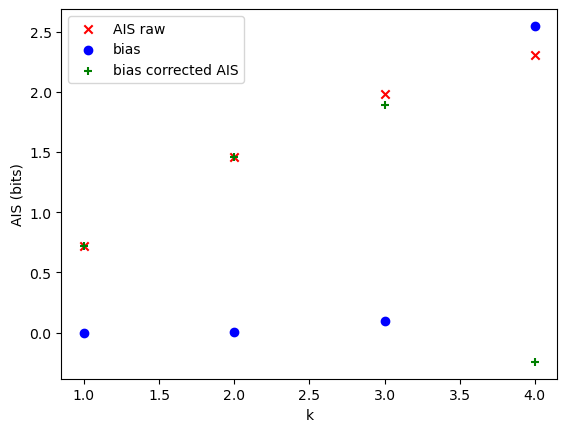

In [3]:
# Paste the code computing AIS vs k here (copy from the CA activity and then we'll adapt):

kMax = 4;
results = numpy.zeros((kMax))
biases = numpy.zeros((kMax))
biasCorrectedResults = numpy.zeros((kMax))

for k in range(1,kMax+1):
    # 1. Construct the calculator:
    calcClass = JPackage("infodynamics.measures.discrete").ActiveInformationCalculatorDiscrete
    calc = calcClass(27, k)
    # 2. No other properties to set for discrete calculators.
    
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()
    
    # Pass in the whole time series at once now:
    variable = JArray(JInt, 1)(data.tolist())
    
    # 4. Supply the sample data:
    calc.addObservations(variable)
    
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations()
    # 6. Compute the (statistical significance via) null distribution analytically:
    measDist = calc.computeSignificance()
    bias = measDist.getMeanOfDistribution()

    # Store the results:
    results[k-1] = result
    biases[k-1] = bias
    biasCorrectedResults[k-1] = result - bias
    
    print("AIS_Discrete(k=%d, %d samples) = %.4f bits (bias %.4f, bias corrected %.4f)" %\
        (k, calc.getNumObservations(), result, bias, result - bias))

optimalK = numpy.argmax(biasCorrectedResults)+1 # Need to add 1 for the array offset
print('Optimal k=%d, giving bias corrected AIS(k=%d)=%.4f bits' % (optimalK,optimalK,biasCorrectedResults[optimalK-1])) # subtract 1 for array indexing

import matplotlib.pyplot as plt
plt.scatter(range(1,kMax+1), results, marker='x', color='red', label='AIS raw')
plt.scatter(range(1,kMax+1), biases, marker='o', color='blue', label='bias')
plt.scatter(range(1,kMax+1), biasCorrectedResults, marker='+', color='green', label='bias corrected AIS')
plt.xlabel('k')
plt.ylabel('AIS (bits)')
plt.legend()
plt.show()

5. Now run the code, and observe how AIS -- both the raw and bias corrected values -- change with history length k.
    * What value of k should we use when computing AIS for this data set?
    * From this data set, how many previous characters are we able to confidently say have an impact on predicting the next character?
    * What sources of error or limitations might there be in our experiment?